In [2]:
import pandas as pd

In [3]:
df = pd.read_csv('train.csv')
df

id  label                                              tweet
0          1      0   @user when a father is dysfunctional and is s...
1          2      0  @user @user thanks for #lyft credit i can't us...
2          3      0                                bihday your majesty
3          4      0  #model   i love u take with u all the time in ...
4          5      0             factsguide: society now    #motivation
...      ...    ...                                                ...
31957  31958      0  ate @user isz that youuu?ðððððð...
31958  31959      0    to see nina turner on the airwaves trying to...
31959  31960      0  listening to sad songs on a monday morning otw...
31960  31961      1  @user #sikh #temple vandalised in in #calgary,...
31961  31962      0                   thank you @user for you follow  

[31962 rows x 3 columns]

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      31962 non-null  int64 
 1   label   31962 non-null  int64 
 2   tweet   31962 non-null  object
dtypes: int64(2), object(1)
memory usage: 749.2+ KB


In [5]:
import re

In [6]:

def clean(text):
  #Replace all digits with space
  text = re.sub(r"[\d-]",'',text)
  # Remove Unicode characters
  text = re.sub(r'[^\x00-\x7F]+', '',text)
  #Remove retweets
  text = re.sub('user', '', text)
  # Remove urls
  text = re.sub(r'https?:\/\/[A-Za-z0-9\.\/]+', '', text)
  text = re.sub("[^a-zA-Z]", ' ',text)
  # Remove mentions:
  text = re.sub(r'@[A-Za-z0-9_]+', '', text)
  return text

df.tweet = df.tweet.apply(clean)

In [7]:
df

id  label                                              tweet
0          1      0     when a father is dysfunctional and is so se...
1          2      0      thanks for  lyft credit i can t use cause ...
2          3      0                                bihday your majesty
3          4      0   model   i love u take with u all the time in ...
4          5      0             factsguide  society now     motivation
...      ...    ...                                                ...
31957  31958      0                             ate   isz that youuu  
31958  31959      0    to see nina turner on the airwaves trying to...
31959  31960      0  listening to sad songs on a monday morning otw...
31960  31961      1     sikh  temple vandalised in in  calgary   ws...
31961  31962      0                       thank you   for you follow  

[31962 rows x 3 columns]

<AxesSubplot:>

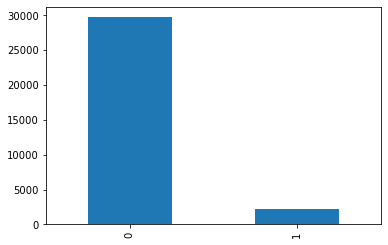

In [8]:
df['label'].value_counts().plot(kind='bar')

In [9]:
seq_len = 512
num_samples = len(df)

num_samples, seq_len

(31962, 512)

In [10]:
from transformers import BertTokenizer

In [11]:
# initialize tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [12]:
# tokenize - this time returning Numpy tensors
tokens = tokenizer(df['tweet'].tolist(), max_length=seq_len, truncation=True,
                   padding='max_length', add_special_tokens=True,
                   return_tensors='np')

In [13]:
tokens.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [14]:
tokens['input_ids']

array([[  101,  1165,   170, ...,     0,     0,     0],
       [  101,  5438,  1111, ...,     0,     0,     0],
       [  101, 16516,  1324, ...,     0,     0,     0],
       ...,
       [  101,  5578,  1106, ...,     0,     0,     0],
       [  101, 27466,  9862, ...,     0,     0,     0],
       [  101,  6243,  1128, ...,     0,     0,     0]])

In [15]:
tokens['attention_mask']

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])

In [16]:
import numpy as np

In [17]:
with open('tweets_xids.npy', 'wb') as f:
    np.save(f, tokens['input_ids'])

with open('tweets_xmask.npy', 'wb') as f:
    np.save(f, tokens['attention_mask'])

In [18]:
del tokens

In [19]:
arr = df['label'].values
arr, arr.shape

(array([0, 0, 0, ..., 0, 1, 0], dtype=int64), (31962,))

In [20]:
arr.max()+1

2

In [21]:
labels = np.zeros((num_samples, arr.max()+1))
labels.shape

(31962, 2)

In [22]:
labels[np.arange(num_samples),arr] = 1
labels

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [0., 1.],
       [1., 0.]])

In [23]:
with open('tweets_labels.npy', 'wb') as f:
    np.save(f, labels)

In [24]:
with open('tweets_xids.npy', 'rb') as f:
    Xids = np.load(f, allow_pickle=True)
with open('tweets_xmask.npy', 'rb') as f:
    Xmask = np.load(f, allow_pickle=True)
with open('tweets_labels.npy', 'rb') as f:
    labels = np.load(f, allow_pickle=True)

In [25]:
Xids.shape

(31962, 512)

In [26]:
labels

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [0., 1.],
       [1., 0.]])

In [27]:
import tensorflow as tf

In [28]:
dataset = tf.data.Dataset.from_tensor_slices((Xids, Xmask, labels))

dataset.take(1)

<TakeDataset element_spec=(TensorSpec(shape=(512,), dtype=tf.int32, name=None), TensorSpec(shape=(512,), dtype=tf.int32, name=None), TensorSpec(shape=(2,), dtype=tf.float64, name=None))>

In [29]:
def map_funct(ids, mask, labels):
    return {'input_ids': ids, 'attention_mask':mask},labels

dataset = dataset.map(map_funct)

In [30]:
dataset.take(1)

<TakeDataset element_spec=({'input_ids': TensorSpec(shape=(512,), dtype=tf.int32, name=None), 'attention_mask': TensorSpec(shape=(512,), dtype=tf.int32, name=None)}, TensorSpec(shape=(2,), dtype=tf.float64, name=None))>

In [31]:
batch_size = 3

dataset = dataset.shuffle(3000).batch(batch_size, drop_remainder=True)

dataset.take(1)

<TakeDataset element_spec=({'input_ids': TensorSpec(shape=(3, 512), dtype=tf.int32, name=None), 'attention_mask': TensorSpec(shape=(3, 512), dtype=tf.int32, name=None)}, TensorSpec(shape=(3, 2), dtype=tf.float64, name=None))>

In [32]:
#Split training and validation set
split = 0.9

In [33]:
size = int((Xids.shape[0] / batch_size) * split)
size

9588

In [34]:
train_set = dataset.take(size)
val_set = dataset.skip(size)

del dataset

In [35]:
train_set

<TakeDataset element_spec=({'input_ids': TensorSpec(shape=(3, 512), dtype=tf.int32, name=None), 'attention_mask': TensorSpec(shape=(3, 512), dtype=tf.int32, name=None)}, TensorSpec(shape=(3, 2), dtype=tf.float64, name=None))>

In [36]:
tf.data.experimental.save(train_set, 'train')
tf.data.experimental.save(val_set, 'val')

Instructions for updating:
Use `tf.data.Dataset.save(...)` instead.


In [37]:
train_set.element_spec

({'input_ids': TensorSpec(shape=(3, 512), dtype=tf.int32, name=None),
  'attention_mask': TensorSpec(shape=(3, 512), dtype=tf.int32, name=None)},
 TensorSpec(shape=(3, 2), dtype=tf.float64, name=None))

In [38]:
val_set.element_spec == train_set.element_spec

True

In [39]:
ds = tf.data.experimental.load('train', element_spec=train_set.element_spec)

Instructions for updating:
Use `tf.data.Dataset.load(...)` instead.


In [40]:
from transformers import TFAutoModel

In [41]:
bert = TFAutoModel.from_pretrained('bert-base-cased')

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [42]:
# we can view the model using the summary method
bert.summary()

Model: "tf_bert_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  108310272 
                                                                 
Total params: 108,310,272
Trainable params: 108,310,272
Non-trainable params: 0
_________________________________________________________________


In [43]:
# two input layers, we ensure layer name variables match to dictionary keys in TF dataset
input_ids = tf.keras.layers.Input(shape=(512,), name='input_ids', dtype='int32')
mask = tf.keras.layers.Input(shape=(512,), name='attention_mask', dtype='int32')

In [44]:
# we access the transformer model within our bert object using the bert attribute (eg bert.bert instead of bert)
embeddings = bert.bert(input_ids, attention_mask=mask)[0]  # access final activations with [0]

In [45]:
# convert bert embeddings into 2 output classes
x = tf.keras.layers.LSTM(32, dropout=.3, recurrent_dropout=.3, return_sequences=True)(embeddings)
x = tf.keras.layers.LSTM(16, dropout=.4, recurrent_dropout=.4, return_sequences=False)(x)
# normalize
x = tf.keras.layers.BatchNormalization()(x)
# output
x = tf.keras.layers.Dense(64, activation='relu')(x)
y = tf.keras.layers.Dense(2, activation='softmax', name='outputs')(x)

In [46]:
# initialize model
model = tf.keras.Model(inputs=[input_ids, mask], outputs=y)

# (optional) freeze bert layer
#model.layers[2].trainable = False

# print out model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 512)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 512)]        0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 512,                                           

In [47]:
optimizer = tf.keras.optimizers.Adam(lr=1e-4, decay=1e-6)
loss = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[acc])

c:\Users\ReDI_NRW_765\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [48]:
element_spec = ({'input_ids': tf.TensorSpec(shape=(3, 512), dtype=tf.int32, name=None),
                 'attention_mask': tf.TensorSpec(shape=(3, 512), dtype=tf.int32, name=None)},
                tf.TensorSpec(shape=(3, 2), dtype=tf.float64, name=None))
                
# load the training and validation sets
train_ds = tf.data.experimental.load('train', element_spec=element_spec)
val_ds = tf.data.experimental.load('val', element_spec=element_spec)

# view the input format
train_ds.take(1)

<TakeDataset element_spec=({'input_ids': TensorSpec(shape=(3, 512), dtype=tf.int32, name=None), 'attention_mask': TensorSpec(shape=(3, 512), dtype=tf.int32, name=None)}, TensorSpec(shape=(3, 2), dtype=tf.float64, name=None))>

In [49]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=2
)

Epoch 1/2
 229/9588 [..............................] - ETA: 163:49:11 - loss: 0.4691 - accuracy: 0.8355

In [ ]:
model.save('sentiment_model')

INFO:tensorflow:Assets written to: sentiment_model\assets


INFO:tensorflow:Assets written to: sentiment_model\assets


In [ ]:
model = tf.keras.models.load_model('sentiment_model')

# view model architecture to confirm we have save and loaded correctly
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 512)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 512)]        0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 512,                                           

In [ ]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

def prep_data(text):
    tokens = tokenizer.encode_plus(text, max_length=512,
                                   truncation=True, padding='max_length',
                                   add_special_tokens=True, return_token_type_ids=False,
                                   return_tensors='tf')
    # tokenizer returns int32 tensors, we need to return float64, so we use tf.cast
    return {'input_ids': tokens['input_ids'],
            'attention_mask': tokens['attention_mask']}

In [ ]:
import re

In [ ]:
def clean(text):
  #Replace all digits with space
  text = re.sub(r"[\d-]",'',text)
  # Remove Unicode characters
  text = re.sub(r'[^\x00-\x7F]+', '',text)
  #Remove retweets
  text = re.sub('user', '', text)
  # Remove urls
  text = re.sub(r'https?:\/\/[A-Za-z0-9\.\/]+', '', text)
  text = re.sub("[^a-zA-Z]", ' ',text)
  # Remove mentions:
  text = re.sub(r'@[A-Za-z0-9_]+', '', text)
  return text

dfa.Tweets = dfa.Tweets.apply(clean)

In [ ]:
dfa

Tweets  \
0                                            you are correct that Reid certainly is a weasel  Sadly  we ve got our own weasels    Sen McConnell      The corrupt Mueller investigation w be STOPPED if those  did their jobs  MAGA  KAG  POTUS  Trump  NEWS  VoteRed  NoDACA  USA   
1                                                                                                                                                                                                                                          Whoever just unfollowed me you a bitch   
2                                                                                                      Those People Invaded Us    They DO NOT BELING HERE   HAVE NO RIGHTS  Its  AmericaFIRST  Open Your House To Them If Your That IGNORANT    Yes Im A  Christian Too   NODACA    
3                                                                                                                                                 stop JUDGING bitches by there cover  jus cuz she bad don t mean she s a catch shawdy could be a whore  das opposite of a keeper   
4                                                                                                                                                                  how about i knock heads off and send them gift wrapped to your moms house you dumb raggedy bird bitch ass hoes   
..                                                                                                                                                                                                                                                                            ...   
895                                                                                                                                                                                              you my nigga    You a bitch tho I ll fuck you up bitch  k   madden  Anything hoe   
896                                                                                                                              Another brilliant young artist has had his life snuffed out from ingesting poisonous substances     BuildThatWall How many more   OpioidEpidemic   
897        Midterm are more important  I m as big as a  BuildThatWall proponent as there is  but if   does shutdown the  gov it would give the  FakeNews ammunition to convince  WalkAway voters to stay Dem  Socialist progressive   I believe Trump  win and the wall is built    
898                    Five Other Heinous Illegal Alien Crimes You Didnt Hear About This Week MSM refuses to publish or warn citizens of the atrocities being inflicted on them daily by Illegal Aliens Everyday an Illegal Alien destroy s more American family s  DeportThemAll   
899                                                                                                                                                                                                                   Thank you for the Follow   NoAmnesty  EndDACA  BuildTheWall   

    Label  
0       0  
1       0  
2       0  
3       0  
4       0  
..    ...  
895     0  
896     0  
897     0  
898     0  
899     0  

[900 rows x 2 columns]

In [ ]:
probs = model.predict(prep_data("you stink"))[0]

probs

1/1 [==============================] - 3s 3s/step


array([0.9113687, 0.0886312], dtype=float32)

In [ ]:
np.argmax(probs)

0

In [ ]:
dfa['Label'] = None

for i, row in dfa.iterrows():
    # get token tensors
    tokens = prep_data(row['Tweets'])
    # get probabilities
    probs = model.predict(tokens)
    p_pred = probs.flatten()
    print(p_pred.round(2))
    # [1. 0.01 0.91 0.87 0.06 0.95 0.24 0.58 0.78 ...

    # extract the predicted class labels
    y_pred = np.where(p_pred > 0.5, 1, 0)
    #print(y_pred)
    # find argmax for winning class
    #pred = np.argmax(probs)
    # add to dataframe
    dfa.at[i, 'Label'] = y_pred

dfa.head()

1/1 [==============================] - 3s 3s/step


Tweets  \
0      you are correct that Reid certainly is a weasel  Sadly  we ve got our own weasels    Sen McConnell      The corrupt Mueller investigation w be STOPPED if those  did their jobs  MAGA  KAG  POTUS  Trump  NEWS  VoteRed  NoDACA  USA   
1                                                                                                                                                                                                    Whoever just unfollowed me you a bitch   
2                                                                Those People Invaded Us    They DO NOT BELING HERE   HAVE NO RIGHTS  Its  AmericaFIRST  Open Your House To Them If Your That IGNORANT    Yes Im A  Christian Too   NODACA    
3                                                                                                           stop JUDGING bitches by there cover  jus cuz she bad don t mean she s a catch shawdy could be a whore  das opposite of a keeper   
4                                                                                                                            how about i knock heads off and send them gift wrapped to your moms house you dumb raggedy bird bitch ass hoes   

  Label  
0     0  
1     0  
2     0  
3     0  
4     0

In [ ]:
dfa.tail(15)

Tweets  \
885                                       You are still stealing valor   credit from   Without     and his minion leadership team  you  would have never reduced our taxes  The  ACA has never been repealed as you promised  whats new   BTW  DeportThemAll  MAGA   for Speaker    
886                                                                                                                                                                                When you wear Olympic weightlifting shoes for squats but still can t hit depth  lol  You bitch   
887                                                                                                                                       Fuck U bitch  He wasn t a fictional person  he was an internet manwhore   He brainwashed me   never wanted to SKYPE ME   he used me for   
888                                                                                                                                                                                                                                    bitch whole pussy out wit some prokeds on    
889                                                                                                                                                                         Mannn shut your bitch ass up   your hoe ass was rooting for George Zimmerman murdering ass   Fuck you   
890                                            The only agenda of ABVP  RSS in the universities of India is to divide students community on the basis of communal lines Lets vote for a  GUNDAfreeCampusLet s vote for unityLets vote for NSUI NSUI  DUSU  DUSpeakUp SendThemHome   
891                                                                      The Media is Lying about Chemnitz   Declinist Books Surge in Sales via    defendeurope  stoptheinvasion  WhiteGenocide  openborders  multicultural  diversity  diversityisourstrength  germany  Chemnitz   
892                                                                                                                                     This white lady just told me I was  too young  and  a baby  BITCH I m married with   kids  paying my own goddamn bills   lee me alone hoe   
893                                                                                                                                         Fuck i m drunk but if you meet a mf by the name of tanner parry at any bars by all means fight that bitch he s a hoe ass motherfucker   
894                                                                       How do We Make Babies   White Genocide Propaganda in French Educational Books for Children  defendeurope  stoptheinvasion  WhiteGenocide  openborders  multicultural  diversity  diversityisourstrength   
895                                                                                                                                                                                              you my nigga    You a bitch tho I ll fuck you up bitch  k   madden  Anything hoe   
896                                                                                                                              Another brilliant young artist has had his life snuffed out from ingesting poisonous substances     BuildThatWall How many more   OpioidEpidemic   
897        Midterm are more important  I m as big as a  BuildThatWall proponent as there is  but if   does shutdown the  gov it would give the  FakeNews ammunition to convince  WalkAway voters to stay Dem  Socialist progressive   I believe Trump  win and the wall is built    
898                    Five Other Heinous Illegal Alien Crimes You Didnt Hear About This Week MSM refuses to publish or warn citizens of the atrocities being inflicted on them daily by Illegal Aliens Everyday an Illegal Alien destroy s more American family s  DeportThemAll   
899                                                                                                             

In [ ]:
dft = pd.read_csv('Test_label.csv') # Gold data
dft.head()

Label
0      0
1      1
2      1
3      1
4      1

In [ ]:
test_set = dft['Label']
pred_set = dfa['Label']

In [ ]:
pred_set

0      0
1      0
2      0
3      0
4      0
      ..
895    0
896    0
897    0
898    0
899    0
Name: Label, Length: 900, dtype: object

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, plot_confusion_matrix

In [ ]:
print(confusion_matrix(test_set,pred_set)) #performance measurement
#print(classification_report(test_set,pred_set))
#print("Accuracy:", accuracy_score(test_set,pred_set)*100, "%")

ValueError: Classification metrics can't handle a mix of binary and unknown targets